# Attempting to measure the accuracy of volatility indexs
This notebook will look at how to quantify the effectiveness of a calculated index for any point in time. As these indexs are forward looking the performance of a security over the year following the date of observation will be taken.

In [148]:
%load_ext autoreload
%autoreload 2

import metrics_calc
from vix_calc_class import vix_calc
from vix_alternative import vix_alternative

import sqlite3
import pandas as pd
pd.set_option('display.precision', 2)

import seaborn as sns
from datetime import datetime, timedelta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
DT = '2022-01-07'
d = datetime.strptime(DT, '%Y-%m-%d')

V = vix_calc()
data, vix = metrics_calc.observe_vix_acc(DT, V)
data.head(3)

,open,close,date_of,date_of_close,annual_,vix_t,price_up,price_down,change_ytd
0,476.30,466.09,2022-01-03,2022-01-07,0.00,0.00,466.09,466.09,0.00
1,462.70,464.72,2022-01-10,2022-01-14,0.02,2.51,477.78,454.40,0.29
2,459.74,437.98,2022-01-17,2022-01-21,0.04,3.55,482.62,449.56,6.03


# Aggregate Metrics

In [3]:
# def agg_metrics(df):
#     within, exceeded = metrics_calc.calc_accuracy(df)
#     accuracy = round(within/(within+exceeded), 4)
    
#     stddev = df.close.std()
#     auc, aoc = metrics_calc.calc_auc_aoc(df)
#     yearopen = df.iloc[0].close
#     yearclose = df.iloc[-1].close
#     vixtotal = df.vix_t.sum()
#     return {"accuracy": accuracy, "stddev":stddev, "auc":auc, "aoc":aoc, "yearopen": yearopen,"yearclose":yearclose, "vixtotal":vixtotal}

# def curve_areas(mm, verbose=False):
#     mm['abc'] = mm.auc + mm.aoc
#     mm['rd'] = mm.abc / mm.vixtotal
    
#     if verbose:
#         print(f"Mean Area Under Curve: {mm.auc.mean()}")
#         print(f"Mean Area Over Curve: {mm.aoc.mean()}")
#         print(f"Mean Area Between Curves: {(mm.abc).mean()}")
#         print(f'Ratio : {mm.rd.mean()}')

## Measure Classic VIX

In [150]:
data, vix = metrics_calc.observe_vix_acc(DT, vix_method=V)
vix

18.11287154256035

In [187]:
startdt = '2019-03-08'
startdate = datetime.strptime(startdt, '%Y-%m-%d').date()

enddate = startdate + timedelta(weeks=60)
all_data = {}
metric_data = []
for p in range(52):
    mets = {}
    dt = startdate + timedelta(weeks=p)
    mets['date'] = dt.strftime('%Y-%m-%d')
    data, vix = metrics_calc.observe_vix_acc(dt.strftime('%Y-%m-%d'), vix_method=V)
    mets['vix'] = vix
    
    mets.update(metrics_calc.aggregate_metrics.agg_metrics(data))

    metric_data.append(mets)
    all_data[dt.strftime('%Y-%m-%d')] = data


In [188]:
mm = pd.DataFrame.from_dict(metric_data)
mm = mm.dropna()
mm.head(3)

,date,vix,accuracy,stddev,auc,aoc,yearopen,yearclose,vixtotal
0,2019-03-08,15.20,0.53,16.08,85.44,-65.82,274.46,297.46,533.50
1,2019-03-15,12.67,0.70,16.26,112.35,-52.59,281.31,269.32,444.52
2,2019-03-22,16.19,0.74,18.87,156.63,-27.96,279.25,228.80,568.28


In [189]:
metrics_calc.aggregate_metrics.curve_areas(mm, verbose=True)

Mean Area Under Curve: 537.8709048105815
Mean Area Over Curve: -59.251465725931205
Mean Area Between Curves: 478.6194390846504
Ratio : 0.25132345511258075


In [190]:
mm.describe()

,vix,accuracy,stddev,auc,aoc,yearopen,yearclose,vixtotal,abc,rd
count,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00
mean,24.72,0.72,25.48,537.87,-59.25,301.42,331.08,867.54,478.62,0.25
std,69.80,0.10,5.99,2453.04,41.05,16.48,39.78,2449.43,2462.35,0.17
min,11.79,0.53,16.08,85.44,-176.30,274.46,228.80,413.75,-9.26,-0.02
25%,12.33,0.65,21.06,143.18,-70.35,289.49,304.24,432.76,59.43,0.13
50%,14.10,0.71,23.74,183.97,-45.99,296.73,334.31,494.84,122.97,0.24
75%,16.18,0.81,29.03,235.45,-32.19,313.68,365.64,567.71,180.49,0.38
max,507.62,1.00,39.37,17528.10,0.00,337.60,392.64,17812.56,17528.10,0.98


# Instant metrics

## A look at implied volatilty as prescribed by the vix over a period of time

In [191]:
data_keys = list(all_data.keys())

VIX for 2019-03-08: 15.203634911845082


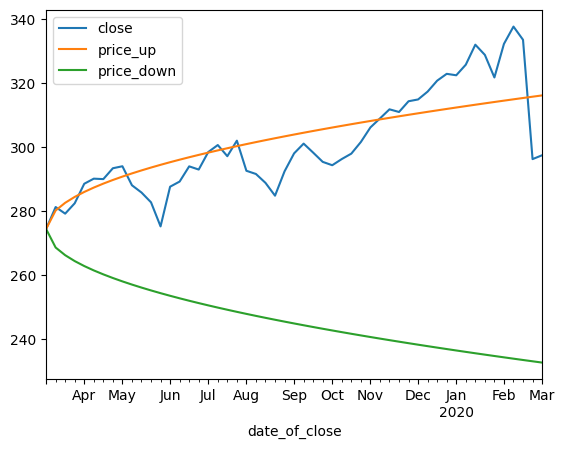

In [192]:
DT = data_keys[0]
data, VIX = metrics_calc.observe_vix_acc(DT, V)
print(f"VIX for {DT}:", VIX)
data.plot(x='date_of_close', y=['close', 'price_up', 'price_down']);

## A look at the absolute change in the SPY (to date), and the prescribed volatility bound

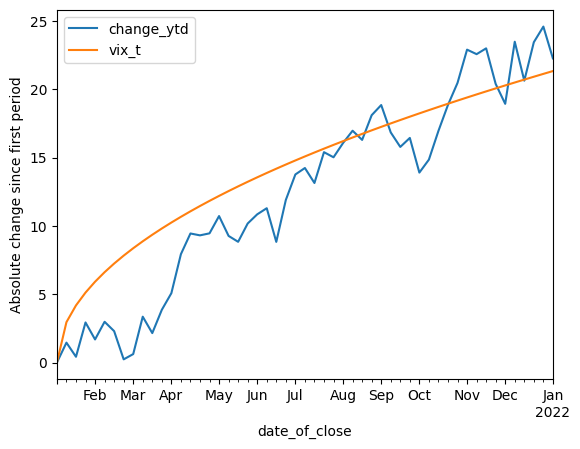

In [61]:
data['change_ytd'] = abs(data.close / data.close.iloc[0] - 1) * 100
ax = data.plot(x='date_of_close', y=['change_ytd', 'vix_t'])
ax.set_ylabel('Absolute change since first period');

## 3 ways of measuring effectiveness for a individual period
1. Count how frequently the SPY leaves the vix bounds
3. Compare Index to the standard deviation of the stocks proven performance
2. Take the difference between the area under the curve for both indexs.

### Simple Accuracy

In [63]:
df = data[['close', 'date_of_close', 'vix_t', 'change_ytd']].copy()

# within, exceeded = df.bounded.value_counts().loc[True], df.bounded.value_counts().loc[False]
within, exceeded = metrics_calc.calc_accuracy(df, real_col='change_ytd')
print('Within Bound:\t', within)
print('Exceeded bound:\t', exceeded)
print('Accuracy: ', round(within/(within+exceeded)*100, 2))

Within Bound:	 41
Exceeded bound:	 12
Accuracy:  77.36


### Standard Deviation
Note: As the standard deviation is an annualised value, for any given point, the difference between the VIX and the STD for the following year can be compared.

In [64]:
print('Standard Deviation:\t\t', df.close.std())
print('Relative Standard Deviation:\t', df.close.std() / df.close.mean() * 100)

Standard Deviation:		 29.20094944725582
Relative Standard Deviation:	 6.82268783252494


### Analysing Curve Areas

In [129]:
data['vix_t2'] = data.annual_.apply(lambda x: metrics_calc.get_period_volatility(2*VIX, x))

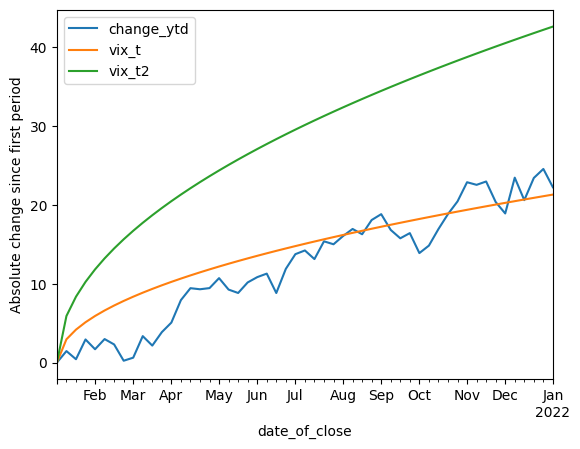

In [130]:
ax = data.plot(x='date_of_close', y=['change_ytd', 'vix_t', 'vix_t2'])
ax.set_ylabel('Absolute change since first period');

In [131]:
metrics_calc.aggregate_metrics.agg_metrics(data)

{'accuracy': 0.7736,
 'stddev': 29.20094944725582,
 'auc': 114.58507808106697,
 'aoc': -24.31098607031307,
 'yearopen': 381.26,
 'yearclose': 466.09,
 'vixtotal': 749.2469714106387}

In [132]:
curve_aoc, curve_auc = metrics_calc.calc_auc_aoc(data, curveA='change_ytd', curveB='vix_t')
print(f"Area under Curve {curve_auc}\nArea Over Curve\t {curve_aoc}")

Area under Curve -24.31098607031307
Area Over Curve	 114.58507808106697


In [133]:
data[data.curve_diff > 0].curve_diff.sum()

AttributeError: 'DataFrame' object has no attribute 'curve_diff'

### Analysing MAE MSE

In [92]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn import metrics

In [136]:
test_data = data.iloc[1:].copy()
chg_pct, vix_t_pct = test_data.change_ytd/100, test_data.vix_t/100
mean_squared_error(chg_pct, vix_t_pct)

0.0010821515573708666

In [137]:
# chg_pct, vix_t_pct = data.change_ytd/100, data.vix_t/100
mean_absolute_error(test_data.change_ytd, test_data.vix_t)

2.671078156757308

In [138]:
test_data['std'] = test_data.change_ytd / test_data.vix_t

In [146]:
test_data['std'].mean()

0.7920015769929308